<a href="https://colab.research.google.com/github/Tookss55/DS/blob/main/Unit5/Unit5ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# Unit 5 Exercises: Leverage + Practice with GLMs

In these exercises, we'll focus on:
- how to recognize high leverage values, and what to do about them.
- how to decide when a generalized linear model is better than than an all normal, straight line model

We'll start  by looking at the full NBA data set from class, and interogate why I removed so many observations from that data set.

We'll finish with another classic data set, some deemographic data from the Kalahari !Kung San people collected by Nancy Howell in Botswana between August 1967 and May 1969.

##Leverage

Let's take a look at the full basketball data set.

In [2]:
#load the data into a pandas dataframe, and print it
url_basketball = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv'
#I could have put the url string directly into pd.read_csv()
basketball = pd.read_csv(url_basketball,dtype={'Pos':'category'})

Before, we put a minutes restriction on what players we looked at, and removed anyone who never missed a free throw.

I've commented out that code, for reference, below. We're going to attempt to run the same analysis without removing any data

In [3]:
#only look at players who played more than 400 minutes
#basketball = basketball.query('MP > 400')
#remove players who never missed a free throw
#basketball = basketball.query('`FT%` != 1.0')

In [4]:
basketball

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


**Task1**:

Make a scatter plot with FT% of each player on the horizontal axis and FG% on the vertical axis.

What patterns do you notice? Why do you think they are there?

<Axes: xlabel='FT%', ylabel='FG%'>

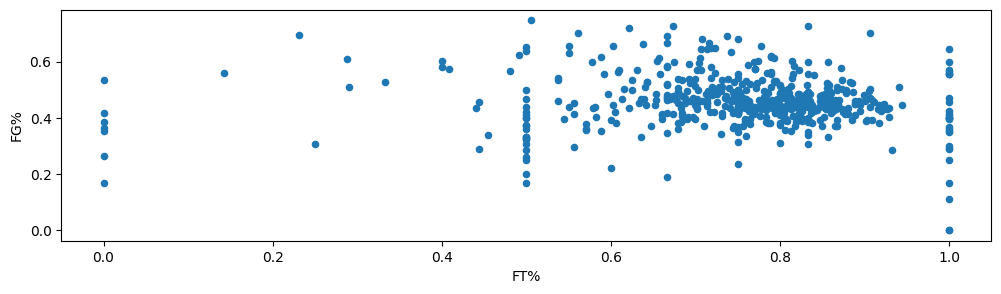

In [5]:
basketball.plot(x="FT%", y="FG%", figsize=(12, 3), kind="scatter")

There are a few points that stick out from the main group in the 0.6–0.8 free throw percentage (FT%) range—these are at 0, 0.5, and 1.0 FT%. These usually happen with players who only took a few free throws and either missed all, made half, or made them all. Basically, these are just cases with very small sample sizes.

The main group includes players who play more minutes,around 20–35 per game, so they have more chances to take free throws. A 0.6–0.9 FT% is pretty common for these role players—solid players who aren’t stars but play regularly.

You can also see that free throw percentages are usually higher than field goal percentages (FG%). Free throws are easier, so most of the dots are above 0.5 FT%, while a lot are below 0.5 FG%.

**Task2**:

Make a scatter plot with FT% on the horizontal axis and FG% on the vertical axis. Do this for each each Position in the data set.

Pay special attention to the plots for C and PF.

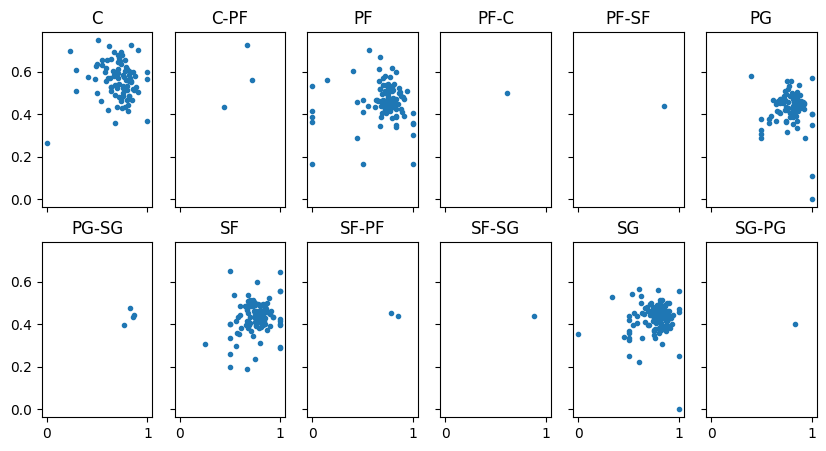

In [6]:
#this is an array for the positions of the players
pos_idx = basketball.Pos.cat.codes.values
pos_codes = basketball.Pos.cat.categories


bb_coords = {"pos": pos_codes}


#set up
_, ax = plt.subplots(2, 6, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

#now this will make a scatter plot for each position
for i, p in enumerate(pos_codes):
    ax[i].scatter(
        x = basketball.query('Pos == @p')['FT%'],
        y =  basketball.query('Pos == @p')['FG%'],
        marker=".")
    ax[i].set_title(f"{p}")



**Task3**:

Originally, I was going to get you to create and run an individual linear regression model for each of the positions.

But I couldn't even get model to run.

Explain why a linear regression model won't run on the full dataset. HInt: look at the graphs you made above, and compare and contrast them to the ones from class.

Or: if you do what I could not and get a linear regression model to run on the full data set, I'll give you full credit and a high five.

One reason a linear regression might not work well is that outliers can mess with the line of best fit. In this case, some of those outliers are also leverage points, which makes things complicated. For example, look at the Center scatterplot. Most of the points seem to trend downward, so the line should follow that. But there’s a point in the bottom left that throws it off and confuses the model. That might be why the model ends up giving negative alpha, beta, and sigma values, which normally shouldn’t happen.

## From Linear Model to Generalized Linear Model

You'll now fit a linear regression on the height and weight for people or the Kalahari !Kung San people. Height will be the predictor and weight will be the predicted.

Here's the raw data.

In [7]:
#downloads the data from my github
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')

In [8]:
howell

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


**Task4**:

Make a scatter plot of height versus weight for the howell data set.

Text(0, 0.5, 'weight')

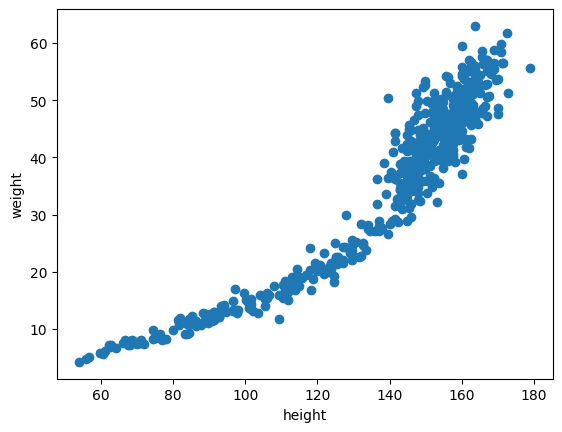

In [9]:
plt.scatter(howell['height'] , howell['weight'],)
#labels
plt.xlabel("height")
plt.ylabel("weight")

This one makes logical sense considering the taller people get the more they weigh.

**Task5**:

Create and run a stright line linear regression model on the howell data set with height predicting weight. Visualize your model and its posterior.

In [ ]:
with pm.Model() as model_hw:
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)
    μ = pm.Normal("μ", α + β * howell.height)
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    #inference data object
    idata_hw = pm.sample()


#takes 100 samples
posterior = az.extract(idata_hw, num_samples=100)


Text(0, 0.5, 'Weight')

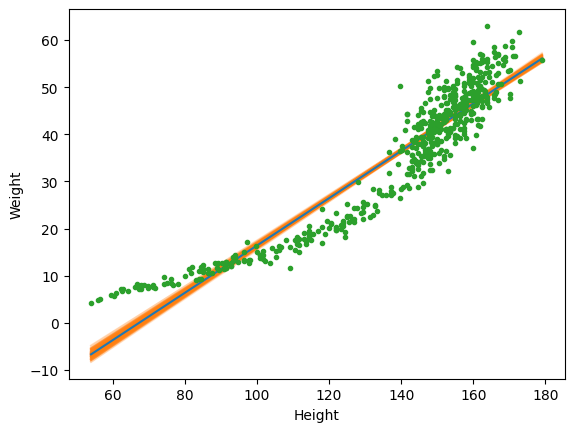

In [51]:
# takes x value from each sample for graphing.
x_plot = xr.DataArray(
    np.linspace(howell.height.min(), howell.height.max(), 50),
    dims="plot_id"
    )

mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

lines = posterior["α"] + posterior["β"] * x_plot

#sets up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2)

#mean line
ax.plot(x_plot, mean_line, c="C0")

#raw data
ax.plot(howell.height, howell.weight, "C2.")

#labels
ax.set_xlabel("Height")
ax.set_ylabel("Weight")


**Task6**:

Run a posterior predictive check for model_howell, plot the posterior predictive distribution, and comment on the fit of the model you made in Task5.

In [ ]:
pm.sample_posterior_predictive(idata_h_w, model=model_h_w,  extend_inferencedata=True)

(-100.0, 100.0)

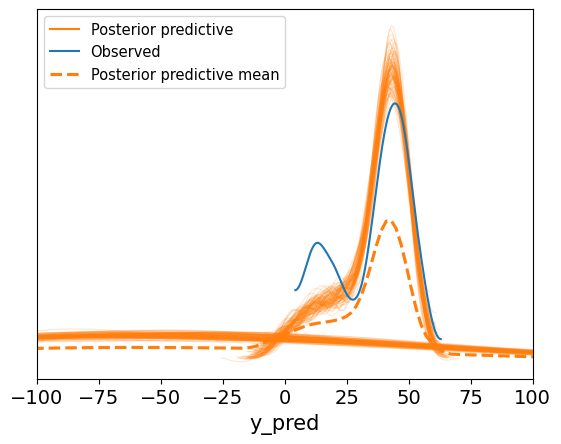

In [44]:
ax = az.plot_ppc(idata_h_w, num_pp_samples=200, colors=["C1", "C0", "C1"])
ax.set_xlim(-100,100)

The actual model looks pretty good, but the posterior predictive check shows that my model is in fact not pretty good. The mean line on the graph follows the trend pretty well. On the posterior predictive check, the posterior predictive mean doesn't peak high enough. Half of the posterior precitive lines do follow the obsered data quite well, but the other half look completely unrelated, which are dragging my posterior predictive mean down.

**Task7**:

Create and visualize the posterior of a generalized linear model that improves the on the fit of the model you made in Task5.

In [ ]:
with pm.Model() as model_hw2:
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)
    μ = pm.Deterministic("μ", α + β * howell.height)
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    #inference data object
    idata_hw2 = pm.sample()


#takes 100 samples
posterior = az.extract(idata_hw, num_samples=100)

Text(0, 0.5, 'Weight')

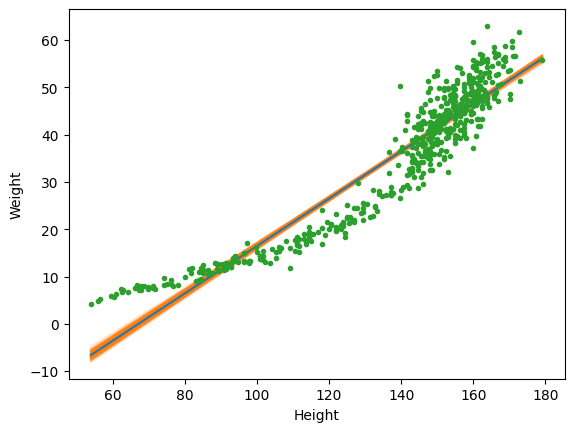

In [57]:
# takes x value from each sample for graphing.
x_plot = xr.DataArray(
    np.linspace(howell.height.min(), howell.height.max(), 50),
    dims="plot_id"
    )

mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

lines = posterior["α"] + posterior["β"] * x_plot

#sets up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2)

#mean line
ax.plot(x_plot, mean_line, c="C0")

#raw data
ax.plot(howell.height, howell.weight, "C2.")

#labels
ax.set_xlabel("Height")
ax.set_ylabel("Weight")


**Task8**:

Run a posterior predictive check, and visualize the posterior predictive distribution, for the model you made in Task7.

Comment on the fit.

In [ ]:
pm.sample_posterior_predictive(idata_hw2, model=model_hw2,  extend_inferencedata=True)

(-100.0, 100.0)

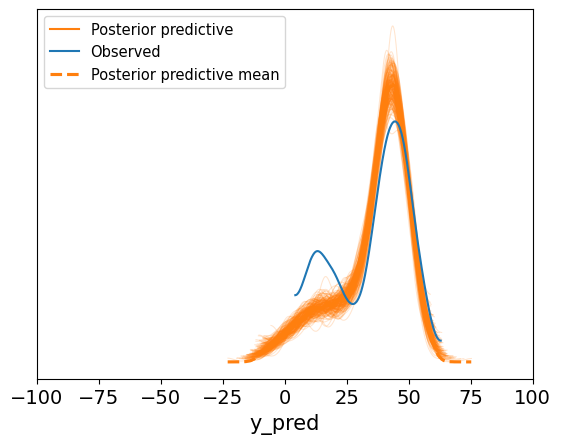

In [59]:
ax = az.plot_ppc(idata_hw2, num_pp_samples=200, colors=["C1", "C0", "C1"])
ax.set_xlim(-100,100)

This model is significantly better. While it doesn't count for the second peak seen in the observed data, it matches the first peak much better.